In [ ]:
from time import time
# simple stopwatch to time whatevs, in (float) seconds
# keeps track of laps along with final time
class Stopwatch:
    def __init__(self):
            self.start_time = time()
            self.last_time = self.start_time
            self.laps = []
    def lap(self):
        this_time = time()
        delta_time = this_time - self.last_time
        self.laps.append(delta_time)
        self.last_time = this_time
        return delta_time
    def stop(self):
        self.stop_time = time()
        self.delta_time = self.stop_time - self.start_time
        return self.delta_time

In [1]:
import json
import numpy as np
import os

data_dir = 'data/'
observations = {}
files = os.listdir(data_dir)
for fname in files:
    fpath = data_dir + fname
    if 'observations' in fname:
        observation_set = np.load(fpath, allow_pickle=True)
        observations.update(observation_set)
Xs = {
    'train':[],
    'val':[],
    'test':[],
}
Ys = {
    'train':[],
    'val':[],
    'test':[],
}
Qs = {
    'train':[],
    'val':[],
    'test':[],
}
nSteps = []
for fname in files:
    fpath = data_dir + fname
    if 'states' in fname:
        jdict = json.load(open(fpath, 'r'))
        for episode in jdict:
            gfile = jdict[episode]['step_0']['fname']
            if 'part2' in gfile or 'part3' in gfile or 'horizontal' in gfile:
                continue
            if 'train' in gfile:
                batch = 'train'
            if 'val' in gfile:
                batch = 'val'
            if 'test' in gfile:
                batch = 'test'
            nSteps.append(len(jdict[episode])-1)
            start = np.array(jdict[episode]['step_0']['drone_position'], dtype=float)
            goal = np.array(jdict[episode]['step_0']['goal_position'], dtype=float)
            last_distance = np.linalg.norm(goal-start)
            rs = []
            for step in jdict[episode]:
                if step == 'step_0':
                    continue
                state = jdict[episode][step]
                actions = state['rl_output']
                observation_name = state['observation_name']
                observation = observations[observation_name]
                Xs[batch].append(list(observation))
                Ys[batch].append(list(np.clip(actions,-1,1)))
                drone = np.array(state['drone_position'], dtype=float)
                this_distance = np.linalg.norm(goal-drone)
                delta_distance = last_distance - this_distance
                last_distance = this_distance
                if delta_distance <= 4:
                    r = 100
                else:
                    r = .1*np.tanh(delta_distance) - 1
                rs.append(r)
            qs = [100]
            gamma = 0.99
            for i in range(len(rs)-2,-1,-1):
                qs.append(rs[i] + gamma * qs[-1])
            qs = qs[::-1]
            Qs[batch] = Qs[batch] + qs
for batch in Xs:
    Xs[batch] = np.array(Xs[batch])
for batch in Ys:
    Ys[batch] = np.array(Ys[batch])
for batch in Qs:
    Qs[batch] = np.array(Qs[batch])

In [2]:
import torch
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, q):
        self.X = torch.as_tensor(X.copy(), device = torch.device("cuda")).float()
        self.y = torch.as_tensor(y.copy(), device = torch.device("cuda")).float()
        self.q = torch.as_tensor(q.copy(), device = torch.device("cuda")).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index], self.q[index]
    
training_set = Dataset(Xs['train'], Ys['train'], Qs['train'])
validation_set = Dataset(Xs['val'], Ys['val'], Qs['val'])
testing_set = Dataset(Xs['test'], Ys['test'], Qs['test'])

In [3]:
from stable_baselines3 import TD3 as sb3TD3
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
sb3model = sb3TD3.load('random_init_model.zip')
device = torch.device("cuda")
sb3model.actor.cuda()

batch_size = 32
params = {'batch_size': batch_size,
          'shuffle': True,}
training_loader = torch.utils.data.DataLoader(training_set, **params)
params = {'batch_size': batch_size,
          'shuffle': False,}
validation_loader = torch.utils.data.DataLoader(validation_set, **params)
testing_loader = torch.utils.data.DataLoader(testing_set, **params)

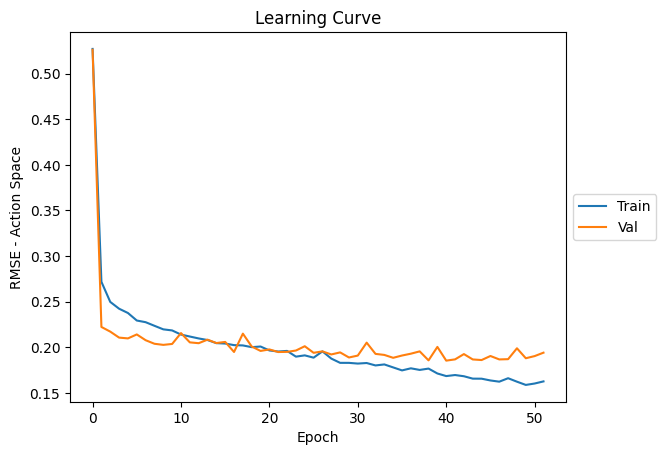

[0.5311453488325576, 0.1733663242449932]


In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy

criterion = nn.MSELoss()
max_epochs = 1000
nTrain = training_set.X.size()[0]
nVal = validation_set.X.size()[0]
nTest = testing_set.X.size()[0]
train_rmses = []
val_rmses = []
patience = 10
wait = 0
best_val = 1
best_weights = copy.deepcopy(sb3model.actor.state_dict())

test_rmses = []
test_sse = 0
for i, data in enumerate(testing_loader):
    x, y, q = data
    p = sb3model.actor(x)
    loss = criterion(p, y)
    test_mse = loss.detach().cpu().numpy()
    test_sse += test_mse * x.size()[0]
test_rmse = math.sqrt(test_sse / nTest)
test_rmses.append(test_rmse)
    
train_sse = 0
for i, data in enumerate(training_loader):
    x, y, q = data
    p = sb3model.actor(x)
    loss = criterion(p, y)
    train_mse = loss.detach().cpu().numpy()
    train_sse += train_mse * x.size()[0]
train_rmse = math.sqrt(train_sse / nTrain)
train_rmses.append(train_rmse)

val_sse = 0
for i, data in enumerate(validation_loader):
    x, y, q = data
    p = sb3model.actor(x)
    loss = criterion(p, y)
    val_mse = loss.detach().cpu().numpy()
    val_sse += val_mse * x.size()[0]
val_rmse = math.sqrt(val_sse / nVal)
val_rmses.append(val_rmse)


for epoch in range(max_epochs):
    
    train_sse = 0
    for i, data in enumerate(training_loader):
        x, y, q = data
        p = sb3model.actor(x)
        loss = criterion(p, y)
        sb3model.actor.optimizer.zero_grad()
        loss.backward()
        sb3model.actor.optimizer.step()
        train_mse = loss.detach().cpu().numpy()
        train_sse += train_mse * x.size()[0]
    train_rmse = math.sqrt(train_sse / nTrain)
    train_rmses.append(train_rmse)
    
    val_sse = 0
    for i, data in enumerate(validation_loader):
        x, y, q = data
        p = sb3model.actor(x)
        loss = criterion(p, y)
        val_mse = loss.detach().cpu().numpy()
        val_sse += val_mse * x.size()[0]
    val_rmse = math.sqrt(val_sse / nVal)
    val_rmses.append(val_rmse)
    
    clear_output(wait=True)
    plt.plot(train_rmses, label='Train')
    plt.plot(val_rmses, label='Val')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE - Action Space')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    if val_rmse < best_val:
        best_val = val_rmse
        best_weights = copy.deepcopy(sb3model.actor.state_dict())
        wait = 0
    else:
        wait += 1
    if wait > patience:
        break
        
sb3model.actor.load_state_dict(best_weights)
        
test_sse = 0
for i, data in enumerate(testing_loader):
    x, y, q = data
    p = sb3model.actor(x)
    loss = criterion(p, y)
    test_mse = loss.detach().cpu().numpy()
    test_sse += test_mse * x.size()[0]
test_rmse = math.sqrt(test_sse / nTest)
test_rmses.append(test_rmse)
print(test_rmses)

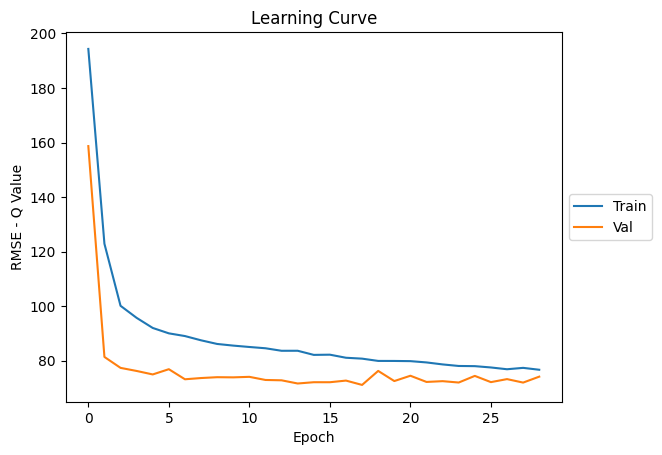

[149.16823210785338, 61.26126774841219]


In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy

criterion = nn.MSELoss()
max_epochs = 1000
nTrain = training_set.X.size()[0]
nVal = validation_set.X.size()[0]
nTest = testing_set.X.size()[0]
train_rmses = []
val_rmses = []
patience = 10
wait = 0
best_val = 999_999
best_weights = copy.deepcopy(sb3model.actor.state_dict())

test_rmses = []
test_sse = 0
for i, data in enumerate(testing_loader):
    x, y, q = data
    ps = sb3model.critic(x, y)
    loss = sum(F.mse_loss(p, q.view(-1, 1)) for p in ps)
    test_mse = loss.detach().cpu().numpy() / 2
    test_sse += test_mse * x.size()[0]
test_rmse = math.sqrt(test_sse / nTest)
test_rmses.append(test_rmse)
    
train_sse = 0
for i, data in enumerate(training_loader):
    x, y, q = data
    ps = sb3model.critic(x, y)
    loss = sum(F.mse_loss(p, q.view(-1, 1)) for p in ps)
    train_mse = loss.detach().cpu().numpy() / 2
    train_sse += train_mse * x.size()[0]
train_rmse = math.sqrt(train_sse / nTrain)
train_rmses.append(train_rmse)

val_sse = 0
for i, data in enumerate(validation_loader):
    x, y, q = data
    ps = sb3model.critic(x, y)
    loss = sum(F.mse_loss(p, q.view(-1, 1)) for p in ps)
    val_mse = loss.detach().cpu().numpy() / 2
    val_sse += val_mse * x.size()[0]
val_rmse = math.sqrt(val_sse / nVal)
val_rmses.append(val_rmse)

for epoch in range(max_epochs):
    
    train_sse = 0
    for i, data in enumerate(training_loader):
        x, y, q = data
        ps = sb3model.critic(x, y)
        loss = sum(F.mse_loss(p, q.view(-1, 1)) for p in ps)
        sb3model.critic.optimizer.zero_grad()
        loss.backward()
        sb3model.critic.optimizer.step()
        train_mse = loss.detach().cpu().numpy() / 2
        train_sse += train_mse * x.size()[0]
    train_rmse = math.sqrt(train_sse / nTrain)
    train_rmses.append(train_rmse)
    
    val_sse = 0
    for i, data in enumerate(validation_loader):
        x, y, q = data
        ps = sb3model.critic(x, y)
        loss = sum(F.mse_loss(p, q.view(-1, 1)) for p in ps)
        val_mse = loss.detach().cpu().numpy() / 2
        val_sse += val_mse * x.size()[0]
    val_rmse = math.sqrt(val_sse / nVal)
    val_rmses.append(val_rmse)
    
    clear_output(wait=True)
    plt.plot(train_rmses, label='Train')
    plt.plot(val_rmses, label='Val')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE - Q Value')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    if val_rmse < best_val:
        best_val = val_rmse
        best_weights = copy.deepcopy(sb3model.actor.state_dict())
        wait = 0
    else:
        wait += 1
    if wait > patience:
        break
        
sb3model.actor.load_state_dict(best_weights)
        
test_sse = 0
for i, data in enumerate(testing_loader):
    x, y, q = data
    ps = sb3model.critic(x, y)
    loss = sum(F.mse_loss(p, q.view(-1, 1)) for p in ps)
    test_mse = loss.detach().cpu().numpy() / 2
    test_sse += test_mse * x.size()[0]
test_rmse = math.sqrt(test_sse / nTest)
test_rmses.append(test_rmse)
print(test_rmses)

In [6]:
torch.save(sb3model.actor.state_dict(), 'actor_weights.pt')
torch.save(sb3model.critic.state_dict(), 'critic_weights.pt')

In [7]:
sb3model.actor_target.load_state_dict(copy.deepcopy(sb3model.actor.state_dict()))

<All keys matched successfully>

In [8]:
sb3model.critic_target.load_state_dict(copy.deepcopy(sb3model.critic.state_dict()))

<All keys matched successfully>

In [9]:
sb3model.save('model.pt')